* 按照 baseline 的方式, 直接读取已预处理过后的文件, 进行模型的训练
* 现在需要将图片和 Label 读入内存
    * 预先切分训练/验证集
    * 分别进行存储
* 训练 2 个 epoch
    * 第一个 epoch 的 lr = 0.001
    * 第二个 epoch 的 lr = 0.00002
* 先不对验证集进行预处理, 测试这样预处理效果如何
* 再对验证集进行预处理, 得到每张图片 8 个不同的预测结果, 在做加权平均, 作为该图片的真实预测结果

In [50]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import itertools

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 导入数据

In [51]:
import os

def mkdir_if_not_exist(path):
    if not os.path.exists(os.path.join(*path)):
        os.makedirs(os.path.join(*path))

mkdir_if_not_exist(['../../raw/preprocessing'])

In [52]:
df_train = pd.read_csv('../../raw/train/Annotations/label.csv')
df_train.columns = ['image_id', 'class', 'label']
df_train.head()

,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [53]:
classes = ['collar_design_labels', 'neckline_design_labels', 'skirt_length_labels',
          'sleeve_length_labels', 'neck_design_labels', 'coat_length_labels', 'lapel_design_labels',
          'pant_length_labels']

## 加载数据

In [54]:
cur_class = classes[0]
df_load = df_train[(df_train['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

collar_design_labels: 9058


,image_id,class,label
0,Images/collar_design_labels/0ef580b4deabcd9fa4...,collar_design_labels,ynnnn
1,Images/collar_design_labels/87ccc33937821a97ad...,collar_design_labels,nnynn
2,Images/collar_design_labels/26caac7d1f1b36fb9d...,collar_design_labels,ynnnn
3,Images/collar_design_labels/396ab4e7cbc6798100...,collar_design_labels,nynnn
4,Images/collar_design_labels/fc4a679c2bf209de13...,collar_design_labels,ynnnn


In [55]:
n_ration=0.9
valid_data=df_load[int(n_ration*len(df_load)):]
df_load=df_load[:int(n_ration*len(df_load))]

In [56]:
n = len(df_load)
n_class = len(df_load['label'][0])
width = 299 # 定义图片大小

X_train = np.zeros((n*8, width, width, 3), dtype=np.uint8)
y_train = np.zeros((n*8, n_class), dtype=np.uint8)

## 数据预处理

In [45]:
rootdir = '../../raw/train/Images/{}'.format(cur_class)  # 指明被遍历的文件夹
m = 0
outdir = '../../raw/preprocessing/Images/{}/'.format(cur_class)

for parent, dirnames, filenames in os.walk(rootdir):
    for filename in filenames:
        currentPath = os.path.join(parent, filename)
 
        img = cv2.imread(currentPath)
        dst0 = cv2.resize(img, (299, 299)) # resize 到 299×299
        rows,cols,channel = dst0.shape

        # 顺逆时针旋转 20°
        M1 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1) 
        M2 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1) 
        dst1 = cv2.warpAffine(dst0,M1,(cols,rows))
        dst2 = cv2.warpAffine(dst0,M2,(cols,rows))
        
        # 向下平移 0.2
        M3 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
        dst3 = cv2.warpAffine(dst0,M3,(cols,rows))
        
        # 水平翻转
        dst4 = cv2.flip(dst0, 1)
        
        # 对翻转后图片, 左右旋转 20°
        M4 = cv2.getRotationMatrix2D((cols/2,rows/2),20,1)
        M5 = cv2.getRotationMatrix2D((cols/2,rows/2),-20,1)
        dst5 = cv2.warpAffine(dst4,M4,(cols,rows))
        dst6 = cv2.warpAffine(dst4,M5,(cols,rows))
        
        # 翻转后向下平移 0.2
        M6 = np.float32([[1,0,0],[0,1,int(cols*0.2)]])
        dst7 = cv2.warpAffine(dst4,M6,(cols,rows))
        
        cv2.imwrite(outdir + filename + "-0.jpg", dst0)
        cv2.imwrite(outdir + filename + "-1.jpg", dst1)
        cv2.imwrite(outdir + filename + "-2.jpg", dst2)
        cv2.imwrite(outdir + filename + "-3.jpg", dst3)
        cv2.imwrite(outdir + filename + "-4.jpg", dst4)
        cv2.imwrite(outdir + filename + "-5.jpg", dst5)
        cv2.imwrite(outdir + filename + "-6.jpg", dst6)
        cv2.imwrite(outdir + filename + "-7.jpg", dst7)
        m += 1
        if m%100 == 0:
            print('{}/{} images have preprocessed.'.format(m, n))

50/9058 images have preprocessed.
100/9058 images have preprocessed.
150/9058 images have preprocessed.
200/9058 images have preprocessed.
250/9058 images have preprocessed.
300/9058 images have preprocessed.
350/9058 images have preprocessed.
400/9058 images have preprocessed.
450/9058 images have preprocessed.
500/9058 images have preprocessed.
550/9058 images have preprocessed.
600/9058 images have preprocessed.
650/9058 images have preprocessed.
700/9058 images have preprocessed.
750/9058 images have preprocessed.
800/9058 images have preprocessed.
850/9058 images have preprocessed.
900/9058 images have preprocessed.
950/9058 images have preprocessed.
1000/9058 images have preprocessed.
1050/9058 images have preprocessed.
1100/9058 images have preprocessed.
1150/9058 images have preprocessed.
1200/9058 images have preprocessed.
1250/9058 images have preprocessed.
1300/9058 images have preprocessed.
1350/9058 images have preprocessed.
1400/9058 images have preprocessed.
1450/9058 im

## 加载训练集

In [57]:
for i in tqdm(range(n)):
    tmp_label = df_load['label'][i]
#     if len(tmp_label) > n_class:
#         print(df_load['image_id'][i])
    for j in range(8):
        X_train[i*8+j] = cv2.resize(cv2.imread('../../raw/preprocessing/{0}'.format(df_load['image_id'][i] + "-%s.jpg"%j)), (width, width))
        y_train[i*8+j][tmp_label.find('y')] = 1


  4%|▎         | 300/8152 [00:07<03:22, 38.84it/s]
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 8152/8152 [04:34<00:00, 29.70it/s]


## 加载验证集

In [69]:
n_valid = len(valid_data)

X_valid = np.zeros((n_valid*8, width, width, 3), dtype=np.uint8)
y_valid = np.zeros((n_valid*8, n_class), dtype=np.uint8)

In [79]:
# 重置索引
valid_data = valid_data.reset_index(drop=True)

In [80]:
for i in tqdm(range(n_valid)):
    tmp_label = valid_data['label'][i]
#     if len(tmp_label) > n_class:
#         print(df_load['image_id'][i])
    for j in range(8):
        X_valid[i*8+j] = cv2.resize(cv2.imread('../../raw/preprocessing/{0}'.format(valid_data['image_id'][i] + "-%s.jpg"%j)), (width, width))
        y_valid[i*8+j][tmp_label.find('y')] = 1

100%|██████████| 906/906 [00:24<00:00, 36.47it/s]


In [58]:
X.shape, y.shape, 

((65216, 299, 299, 3), (65216, 5))

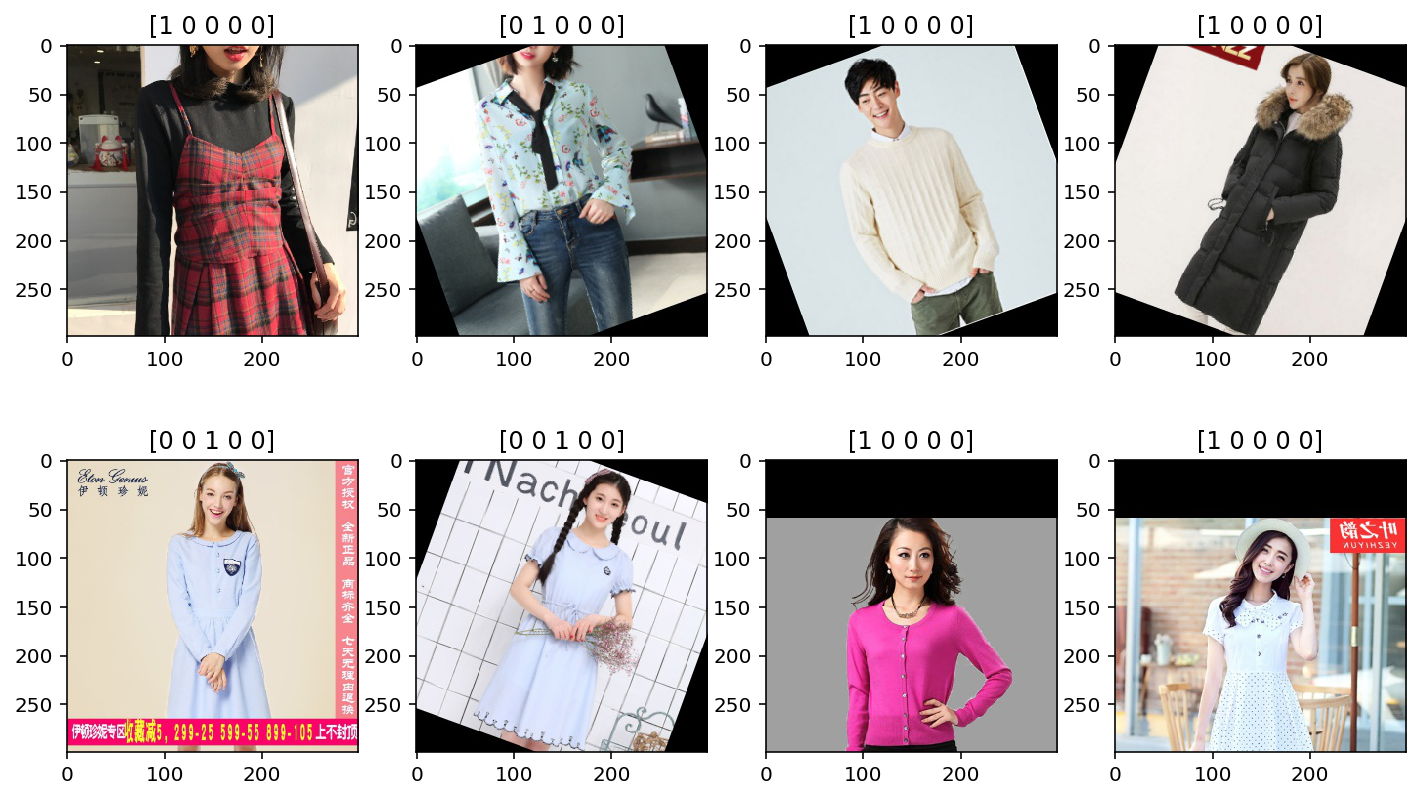

In [59]:
# 随机显示 8 张图片
plt.figure(figsize=(12, 7))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(y[random_index])

## 建立模型

In [81]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [82]:
cnn_model = InceptionResNetV2(include_top=False, input_shape=(width, width, 3), weights='imagenet')
inputs = Input((width, width, 3))

x = inputs
x = Lambda(preprocess_input, name='preprocessing')(x)
x = cnn_model(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax', name='softmax')(x)

model = Model(inputs, x)

In [83]:
adam = Adam(lr=0.001)
prefix_cls = cur_class.split('_')[0]

In [84]:
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0509_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

h = model.fit(X_train, y_train, batch_size=32, epochs=2, 
              callbacks=[EarlyStopping(patience=3), checkpointer], 
              shuffle=True, 
              validation_data=(X_valid, y_valid))

In [ ]:
# 学习率减小 50 倍
adam = Adam(lr=0.00002)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='./models/{0}.best0509_InceptionResNetV2.h5'.format(prefix_cls), verbose=1, 
                               save_best_only=True)

try:
    h = model.fit(X_train, y_train, batch_size=32, epochs=1, 
                  callbacks=[EarlyStopping(patience=3), checkpointer], 
                  shuffle=True, 
                  validation_data=(X_valid, y_valid))
except KeyboardInterrupt:
    print('KeyboardInterrupt')

## 预测结果

In [ ]:
df_test = pd.read_csv('./week-rank/Tests/question.csv', header=None)
df_test.columns = ['image_id', 'class', 'x']
del df_test['x']
df_test.head()

In [ ]:
df_load = df_test[(df_test['class'] == cur_class)].copy()
df_load.reset_index(inplace=True)
del df_load['index']

print('{0}: {1}'.format(cur_class, len(df_load)))
df_load.head()

In [ ]:
n = len(df_load)
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)

for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('./z_rank/{0}'.format(df_load['image_id'][i])), (width, width))

In [ ]:
model.load_weights('./models/{}.best0502_InceptionResNetV2.h5'.format(prefix_cls))

In [ ]:
test_np = model.predict(X_test, batch_size=256)

In [ ]:
result = []

for i, row in df_load.iterrows():
    tmp_list = test_np[i]
    tmp_result = ''
    for tmp_ret in tmp_list:
        tmp_result += '{:.4f};'.format(tmp_ret)
        
    result.append(tmp_result[:-1])

df_load['result'] = result
df_load.head()

In [ ]:
df_load.to_csv('./result/{}_0502_InceptionResNetV2.csv'.format('pant'), header=None, index=False)